# Sheet5 Leonhard Moske


In [1]:
import numpy as np
import itertools as it
import sympy

def genBasis(L, s): #L number of spins, s total spin
    posSpins = np.linspace(-s, s, int((2*s+1)), dtype = float)#generate List of all possible z projections
    #print("possible Spins ", posSpins)
    tmp = it.product(posSpins, repeat = L) # generate object that itterates over all combinations
    return np.asarray([i for i in tmp]) # assemble the list

def Splus(oldcoef, state, site): # site counted from 0 , passed with copy
                        # return new coefficient and new state 
    if (state[site] == 0.5): #s): # if state is s the operator will return 0
        return 0, np.zeros(L)
    # coef = 1  #s = 1/2 #coef = np.sqrt(s*(s+1) - state[site] * (state[site] + 1)) #calculate new coef
    state[site] = 0.5 #state[site] + 1 # update spin state
    return oldcoef, state 

def Sminus(oldcoef, state, site): # analog to Splus
    if (state[site] == -0.5): # -s ):
        return 0, np.zeros(L)
    # coef = 1 #coef = np.sqrt(s*(s+1) - state[site] * (state[site] - 1))
    state[site] = -0.5 # state[site] - 1
    return oldcoef, state #coef*oldcoef 

def Sz(coef, state, site): 
    return state[site]*coef, state

def Hamiltonian(J, statei, L, statej, s):
    H = 0
    # if (np.array_equal(statei, statej)): # is in HamiltonianDiag
    #     for i in range(L):
    #         H += statei[i]*statei[(i+1)%L] * J
            #H += Sz(*Sz(1, np.copy(statei), (i+1)%L), i)[0] * J
    for i in range(L): #apply the operators to every site until L-1
        coef1, state1 = Splus(*Sminus(1, np.copy(statei),(i+1)%L), i)
        coef2, state2 = Sminus(*Splus(1, np.copy(statei), (i+1)%L), i)
        #coef3, state3 = Sz(*Sz(1, np.copy(statei), i+1), i)
        if np.array_equal(state1, statej): #compare if (<i|H)|j> is 0 for every term
            H += coef1*J*0.5
        if np.array_equal(state2, statej):
            H += coef2*J*0.5
        #if np.array_equal(state3, statej):
        #    H += coef3 * J
    return H

def HamiltonianOpen(J, statei, L, statej, s):
    H = 0
    # if (np.array_equal(statei, statej)): # is in HamiltonianDiag
    #     for i in range(L):
    #         H += statei[i]*statei[(i+1)%L] * J
            #H += Sz(*Sz(1, np.copy(statei), (i+1)%L), i)[0] * J
    for i in range(L-1): #apply the operators to every site until L-1
        coef1, state1 = Splus(*Sminus(1, np.copy(statei),(i+1)%L), i)
        coef2, state2 = Sminus(*Splus(1, np.copy(statei), (i+1)%L), i)
        #coef3, state3 = Sz(*Sz(1, np.copy(statei), i+1), i)
        if np.array_equal(state1, statej): #compare if (<i|H)|j> is 0 for every term
            H += coef1*J*0.5
        if np.array_equal(state2, statej):
            H += coef2*J*0.5
        #if np.array_equal(state3, statej):
        #    H += coef3 * J
    return H

def HamiltonianDiag(J, statei, L):
    H = 0
    for i in range(L):
        H += statei[i]*statei[(i+1)%L] * J
    return H

def HamiltonianDiagOpen(J, statei, L):
    H = 0
    for i in range(L-1):
        H += statei[i]*statei[(i+1)%L] * J
    return H


def calcMatrix(Basis, J, L, s):# calculate the basis by calculating the hamiltonian with all combination from the basis
    Matrix = np.empty((len(Basis),len(Basis)))
    for i in range(len(Basis)):
        Matrix[i,i] = HamiltonianDiag(J, Basis[i], L)
    for i, j in it.permutations(range(len(Basis)), 2):
        Matrix[i,j] = Hamiltonian(J, Basis[i], L, Basis[j], s)
    return Matrix 

def calcMatrixOpen(Basis, J, L, s):# calculate the basis by calculating the hamiltonian with all combination from the basis
    Matrix = np.empty((len(Basis),len(Basis)))
    for i in range(len(Basis)):
        Matrix[i,i] = HamiltonianDiagOpen(J, Basis[i], L)
    for i, j in it.permutations(range(len(Basis)), 2):
        Matrix[i,j] = HamiltonianOpen(J, Basis[i], L, Basis[j], s)
    return Matrix 


def totalZ(state, L):
    totalZ = 0
    for i in range(L):
        totalZ += Sz(1, state, i)[0]
    return totalZ

def splitBasisTotZ(Basis, L):
    splitBasis= []
    stot = []
    sortedBasis = sorted(Basis, key = lambda state : (totalZ(state, L)))
    tmpBasis = []
    oldz = totalZ(sortedBasis[0],L)
    for state in sortedBasis:
        z = totalZ(state, L)
        if z != oldz:
            splitBasis.append(tmpBasis)
            stot.append(totalZ(state, L))
            tmpBasis = [state]
            oldz = z
        else:
            tmpBasis.append(state)
            oldz = z
    splitBasis.append(tmpBasis)
    stot.append(totalZ(state, L))
    return splitBasis, stot

def totalZmatrix(Basis, L):# calculate the basis by calculating the hamiltonian with all combination from the basis
    Matrix = np.zeros((len(Basis),len(Basis))) # since we know that the basisstates are eigenstates of totalZ we only have to compute the diagonal 
    for i in range(len(Basis)):
        Matrix[i,i] = totalZ(Basis[i], L)
    return Matrix

def transition(state): # numpy array
    newState = np.roll(state,1)
    return newState

def genFamily(state, operator, L): # generate the family of a state with an operator
    """generate the family of a state with an operator"""
    family = np.asarray([state])
    for r in range(1,L):
        family = np.append(family, [operator(family[-1])], axis=0)
    return family

def get_representativ(state, operator, L):
    family = genFamily(state, operator, L)
    tmp = np.copy(family)
    for i in range(len(family[0])): # over the length of the states
       family = family[family[:,i].argsort()]
    for i, s in enumerate(tmp):
        if np.all(s == family[0] ):
            return family[0] ,i
    return family[0] 

def get_norm(state, nk,operator, L ):
    k=2.*np.pi*nk/L
    fam = genFamily(state,operator,L)

    different_states = set()
    for s in fam:
        different_states.add(tuple(s))
    
    prefactors = {s:0.0 for s in different_states}
    
    for r, s, in enumerate(fam):
        prefactors[tuple(s)] += np.exp(1.j*k*r)
    
    norm = 0.0
    for s in prefactors:
        norm += np.abs( prefactors[s] )**2
        
    return np.sqrt(norm)

def calcHam(basis, L,operator):
    hamils = []
    reps={}

    # Create set of representative states, including family size
    for s in basis:
        rep,fam = get_representativ(s,operator,L)[0], genFamily(s,operator,L)[0]
        reps[tuple(rep)] = len(np.unique(fam, axis = 0))

    dim_sum=0

    for nk in range(L):
        nk = nk  # momentum sector
        k=2.*np.pi*nk/L
        sector_reps={}
        
        index = 0
        for rep in reps.keys():
            norm = get_norm(rep,nk, operator, L)
            if abs(norm)>1e-6:
                sector_reps[tuple(rep)] = (norm, index) # for each representative state, we need to get the norm of its corresponding momentum state, and its index in our basis order
                index+=1
        dim=len(list(sector_reps))
        dim_sum+=dim
        
        #print("Got momentum sector nk={} of size {}".format(nk, dim))
        
        Hk = np.zeros( (dim,dim) , dtype=np.complex128 )
        for rep in sector_reps.keys():
            
            norm, index = sector_reps[rep]
            matel=0.0
            ## diagonal terms
            for site in range(L):
                matel+=rep[site]*rep[(site+1)%L]
            Hk[index,index]=matel
                    
            # offdiagonal matrix elements
            for site in range(L):
                if rep[site]!=rep[(site+1)%L]:
                    state2=list(rep)
                    state2[site], state2[(site+1)%L] =  state2[(site+1)%L], state2[site]
                    rep2, num_translations_to_get_rep = get_representativ(state2, operator, L)
                    #print(state2,rep2)
                    
                    if tuple(rep2) in sector_reps:
                        norm2, idx2 = sector_reps[tuple(rep2)]
                        matel = 0.5*norm2/norm*np.exp(-1.j*k*num_translations_to_get_rep)
                        Hk[index,idx2]+=matel
        hamils.append(Hk)
    return hamils
    
from scipy.sparse import csr_matrix 

def lancoz(A, v_un, m): #A is scipy sparse matrix
    n = len(v_un)
    alpha = np.empty(m)
    beta = np.empty(m)
    v = np.empty((m+1,n))
    v0 = v_un / np.linalg.norm(v_un)
    v[0] = v0
    beta[0] = 0
    w = A.dot(v[0])
    alpha[0] = np.dot(w,v[0])
    w = np.add(w, -1*alpha[0]*v[0])
    beta[1] = np.linalg.norm(w)
    v[1] = w/beta[1]
    for j in range(1,m-1):
        w = np.add(A.dot(v[j]), (-1)*beta[j]*v[j-1])
        alpha[j] =  np.dot(w,v[j])
        w = np.add(w, -1*alpha[j]*v[j]) 
        beta[j+1] = np.linalg.norm(w)
        v[j+1] = w/beta[j+1]
    return v, alpha, beta[1:]

def wrapLancoz(csr_matrix, L, m):
    
    v0 = np.random.rand(2**L)
    v, alpha, beta = lancoz(csr_matrix, v0, m)

    T = np.zeros((m,m))

    for i in range(m):
        T[i,i] = alpha[i]
    for i in range(m-1):
        T[i,i+1] = beta[i]
        T[i+1,i] = beta[i]

    return T , v

## Some sanity checks

In [2]:
L = 3

basis = genBasis(L,0.5)

print(basis)

print(calcMatrixOpen(basis,1,L,0.5))

[[-0.5 -0.5 -0.5]
 [-0.5 -0.5  0.5]
 [-0.5  0.5 -0.5]
 [-0.5  0.5  0.5]
 [ 0.5 -0.5 -0.5]
 [ 0.5 -0.5  0.5]
 [ 0.5  0.5 -0.5]
 [ 0.5  0.5  0.5]]
[[ 0.5  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.5  0.   0.   0.   0.   0. ]
 [ 0.   0.5 -0.5  0.   0.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.5  0.   0. ]
 [ 0.   0.   0.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.5  0.  -0.5  0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.5]]


## Exercise 16

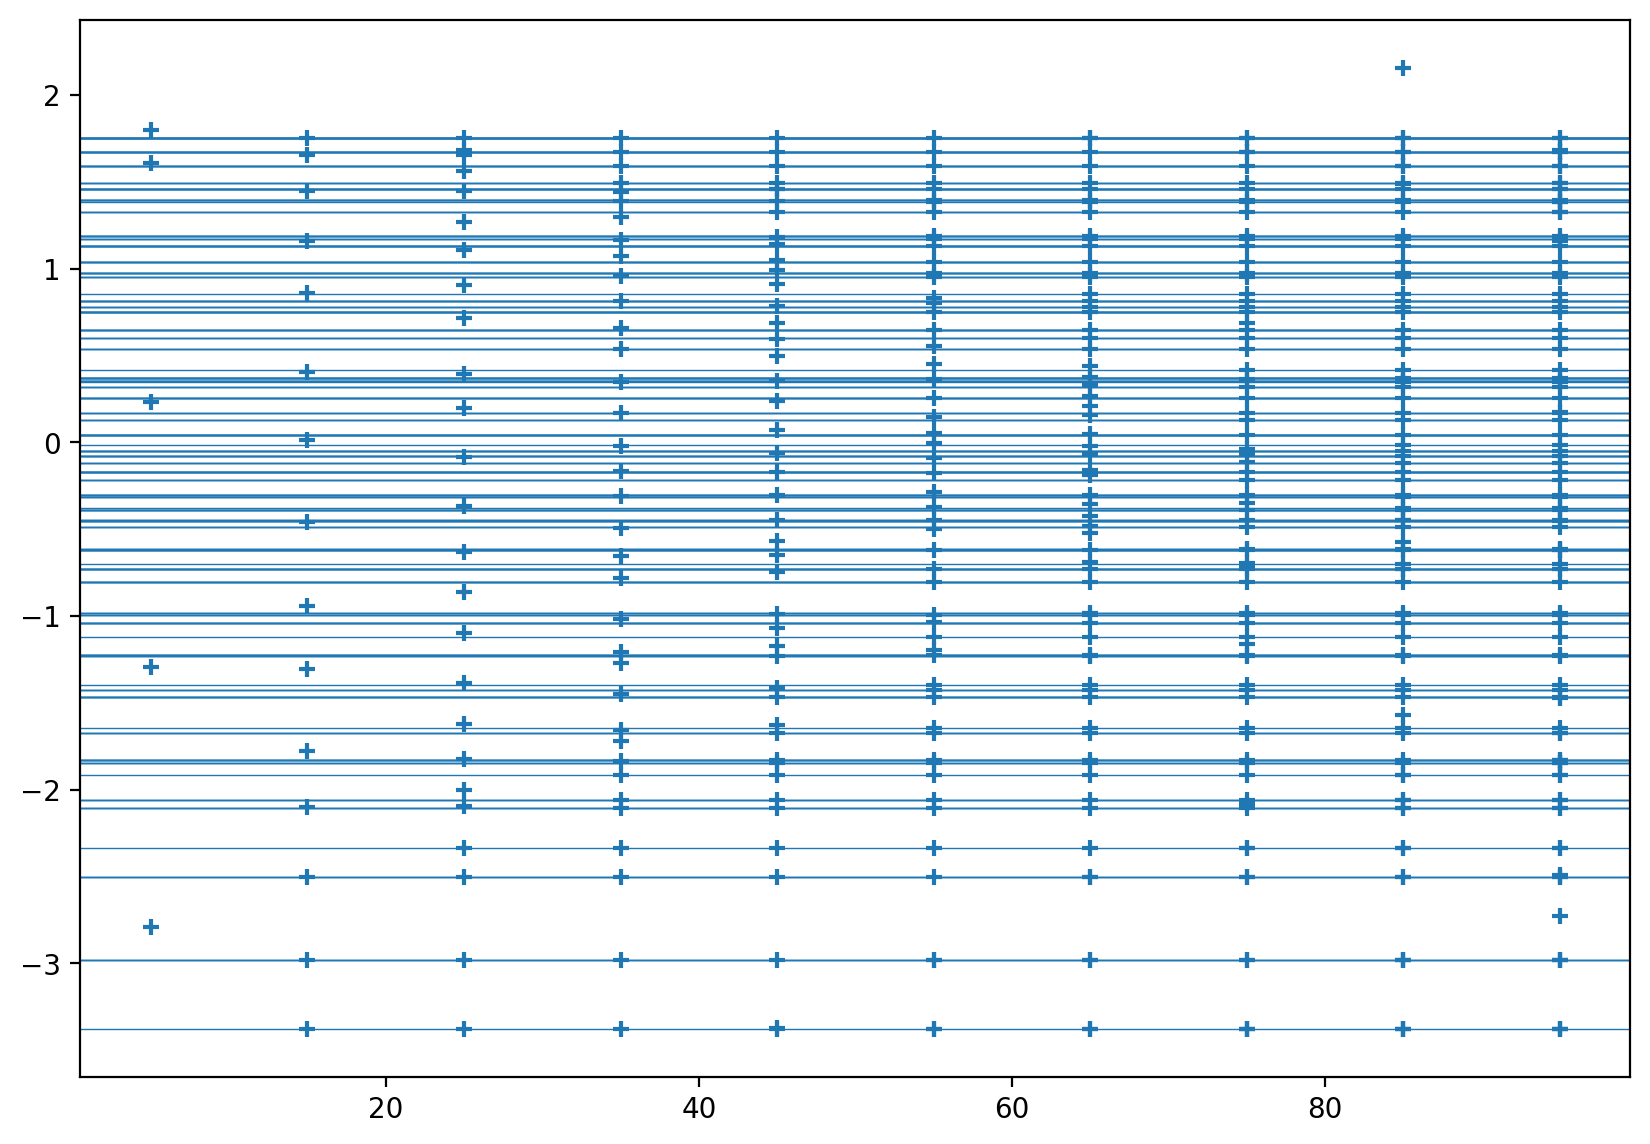

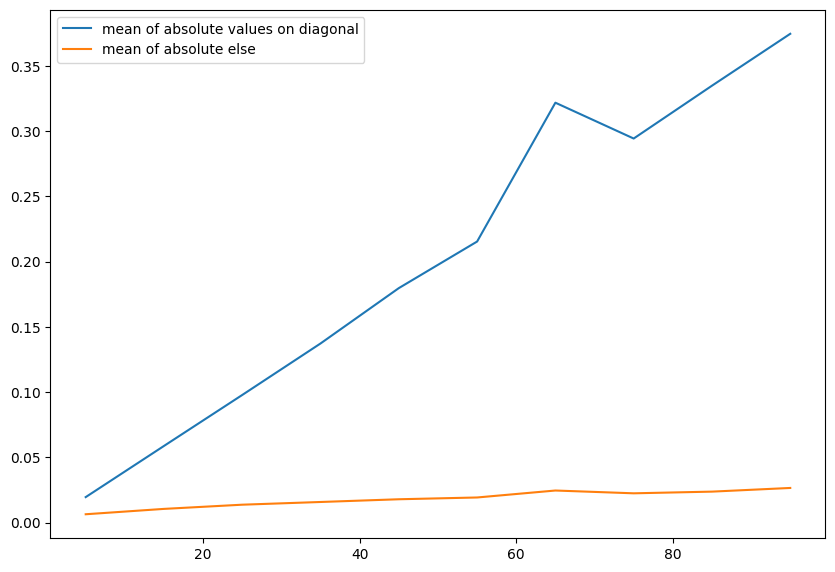

In [3]:
import matplotlib.pyplot as plt
import itertools as it
L = 8  #L = 8 -> 14s -> 10 = 4min

exactEV = np.linalg.eigvals(calcMatrixOpen(genBasis(L,0.5),1,L,0.5))
# print(exactEV)

mat = calcMatrixOpen(genBasis(L,0.5),1,L,0.5)

eigvals = np.empty(0)
plotms = []
diagMean = []
noDiagMean = []
ms = [m for m in range(5,100,10)]
for m in ms:
    t , v = wrapLancoz(csr_matrix(mat),L,m)
    ev = np.linalg.eigvals(t)
    if np.any( ev > 5): # i suspect that in this case the values in the t matrix are not optimal
        t , v = wrapLancoz(csr_matrix(mat),L,m)
        ev = np.linalg.eigvals(t)
    eigvals = np.append(eigvals,ev)
    plotms = np.append(plotms, [m]*len(ev))

    id = np.matmul(np.transpose(v),v)
    if(np.any(id == np.inf) or np.any(id == np.nan)):
        print(id)
        print(v)
    diagMean.append(np.sum(np.absolute(np.diagonal(id)))/np.size(np.diagonal(id)))
    noDiagMean.append((np.sum(np.abs(id)) - np.sum(np.absolute(np.diagonal(id))))/np.size(id))




plt.figure(figsize=(10,7),dpi=200)
for e in exactEV:
    plt.axhline(y = e, lw = 0.5)
plt.scatter(plotms, eigvals, marker = "+")
plt.show()

plt.figure(figsize=(10,7),dpi=100)
plt.plot(ms,diagMean, label = "mean of absolute values on diagonal")
plt.plot(ms,noDiagMean, label = "mean of absolute else")
plt.legend()
plt.show()

## Exercise 17

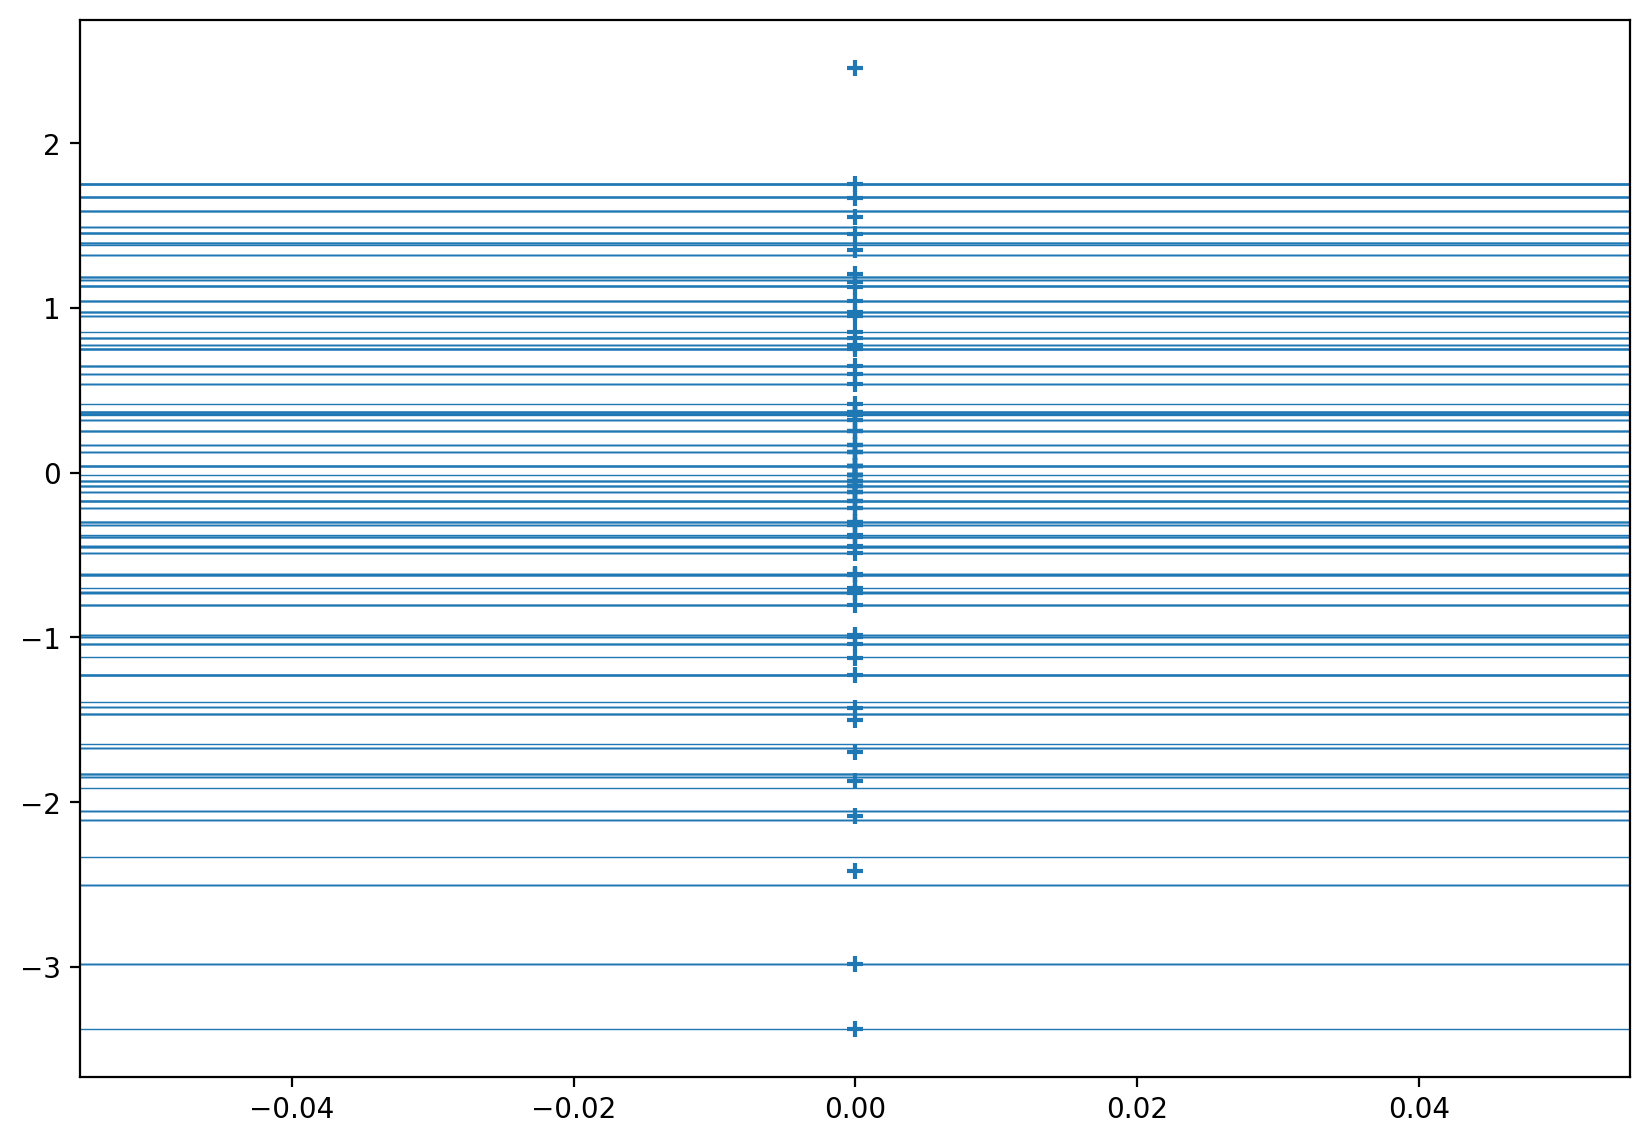

In [4]:
from scipy.linalg import lu_factor, lu_solve

def lancozShiftInverse(A, v_un, m): #A is a normal numpy array
    n = len(v_un)
    alpha = np.empty(m)
    beta = np.empty(m)
    v = np.empty((m+1,n))
    v0 = v_un / np.linalg.norm(v_un)
    v[0] = v0
    beta[0] = 0
    w = gauss(A,v[0]) #  A.dot(v[0])
    alpha[0] = np.dot(w,v[0])
    w = np.add(w, -1*alpha[0]*v[0])
    beta[1] = np.linalg.norm(w)
    v[1] = w/beta[1]
    for j in range(1,m-1):
        w = np.add(gauss(A,v[j]), (-1)*beta[j]*v[j-1])  #np.add(A.dot(v[j]), (-1)*beta[j]*v[j-1])
        alpha[j] =  np.dot(w,v[j])
        w = np.add(w, -1*alpha[j]*v[j]) 
        beta[j+1] = np.linalg.norm(w)
        v[j+1] = w/beta[j+1]
    return v, alpha, beta[1:]


def gauss(mat, vec):
    return lu_solve(lu_factor(mat), vec)

def wrapLancozShiftInverse(matrix, L, m):
    v0 = np.random.rand(2**L)
    v, alpha, beta = lancozShiftInverse(matrix, v0, m)

    T = np.zeros((m,m))

    for i in range(m):
        T[i,i] = alpha[i]
    for i in range(m-1):
        T[i,i+1] = beta[i]
        T[i+1,i] = beta[i]

    return T , v

mat = calcMatrixOpen(genBasis(L,0.5),1,L,0.5)

m = 100

t , v = wrapLancozShiftInverse(mat,L,m)
ev = np.linalg.eigvals(t)
if np.any( ev >2): # i suspect that in this case the values in the t matrix are not optimal
    t , v = wrapLancozShiftInverse(mat,L,m)
    ev = np.linalg.eigvals(t)


plt.figure(figsize=(10,7),dpi=200)
#plt.scatter([0]*len(ev), ev, marker = "+")
plt.scatter([0]*len(ev), np.divide(1,ev), marker = "+")
for e in exactEV:
    plt.axhline(y = e, lw = 0.5)
plt.show()

## Exercise 18

In [5]:
from scipy.sparse.linalg import expm_multiply

phi0 = np.append([0.5]*4,[-0.5]*4) # start for L = 8

basis = genBasis(L,0.5)
# print(basis)
# print(phi0 == basis)
# print(np.all(phi0 == basis, axis = 1))
# print(np.where(np.all(phi0 == basis, axis = 1)))
# print(np.where(np.all(phi0 == basis, axis = 1))[0][0])

phi0n = np.zeros(len(mat[0]))
phi0n[np.where(np.all(phi0 == basis, axis = 1))[0][0]] = 1

m = 50

mat = calcMatrixOpen(genBasis(L,0.5),1,L,0.5)

T, V = wrapLancoz(csr_matrix(mat),L, m)

#exponentiate H on phi0

tstart = 0
tstop = 80
num = 200

phi1 = expm_multiply(mat*-1*1j,phi0n,tstart,tstop,num, endpoint=True)





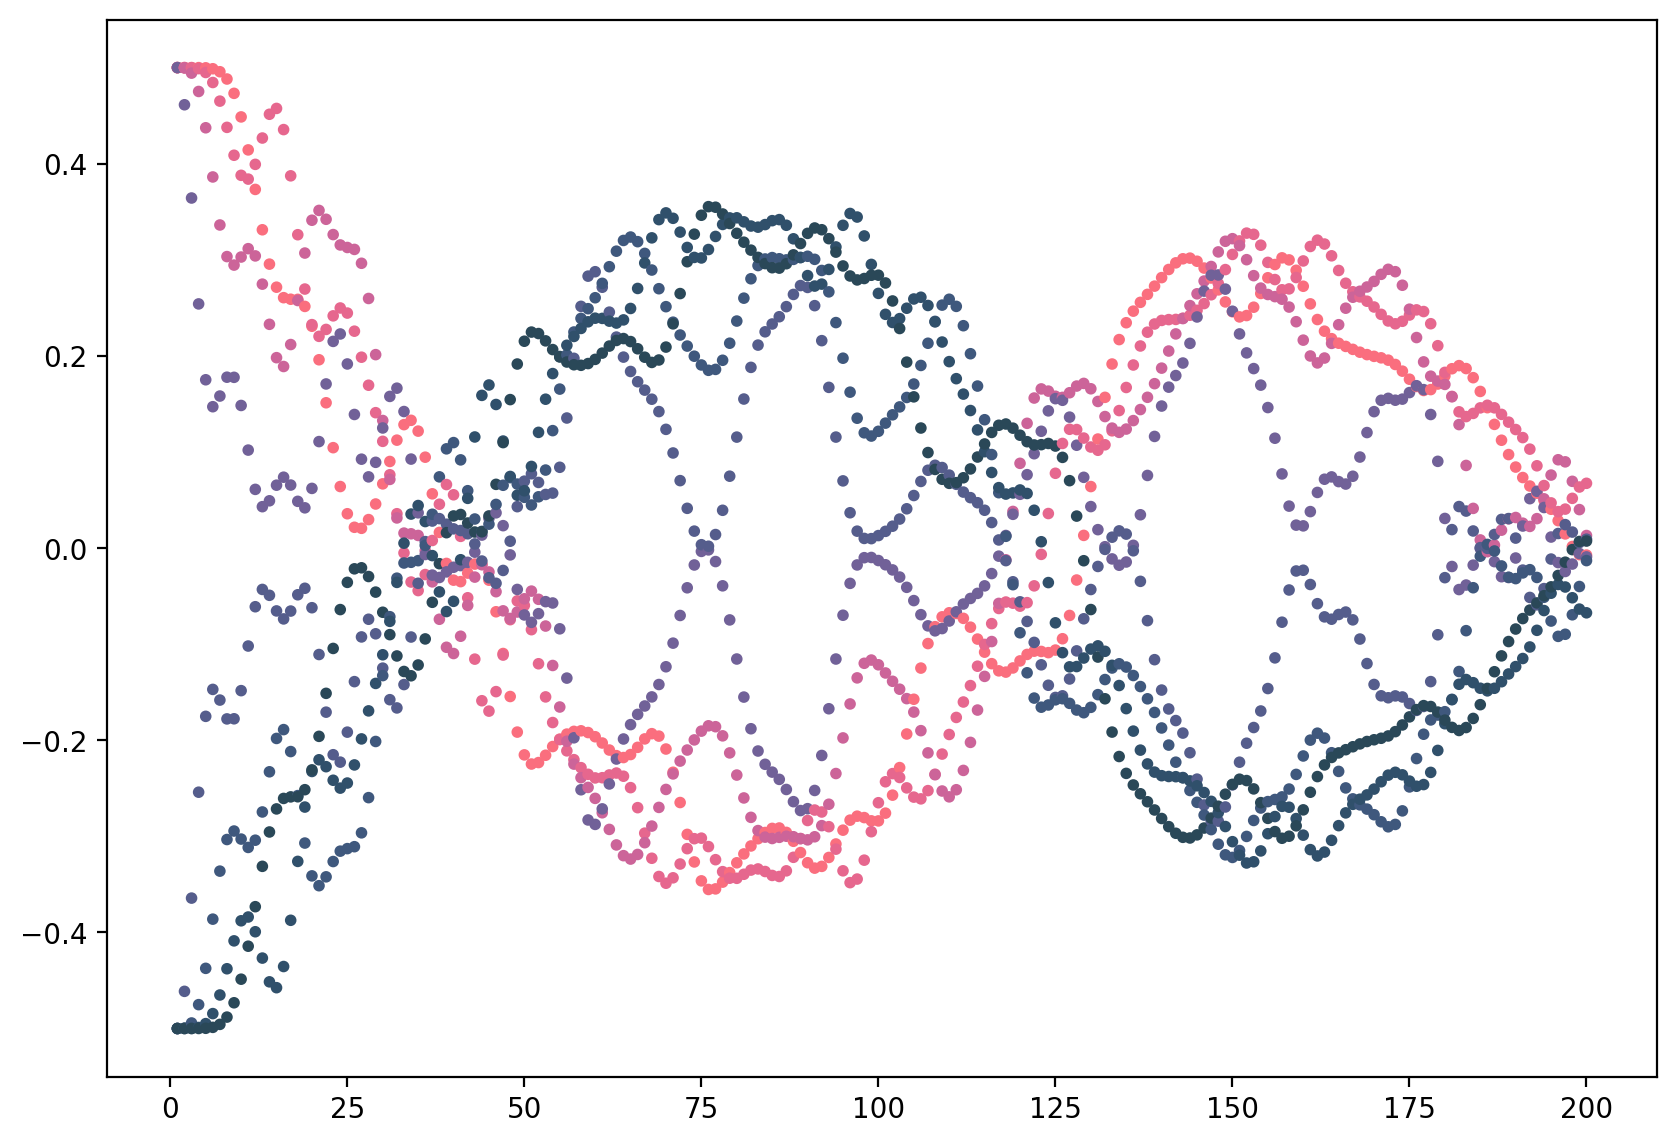

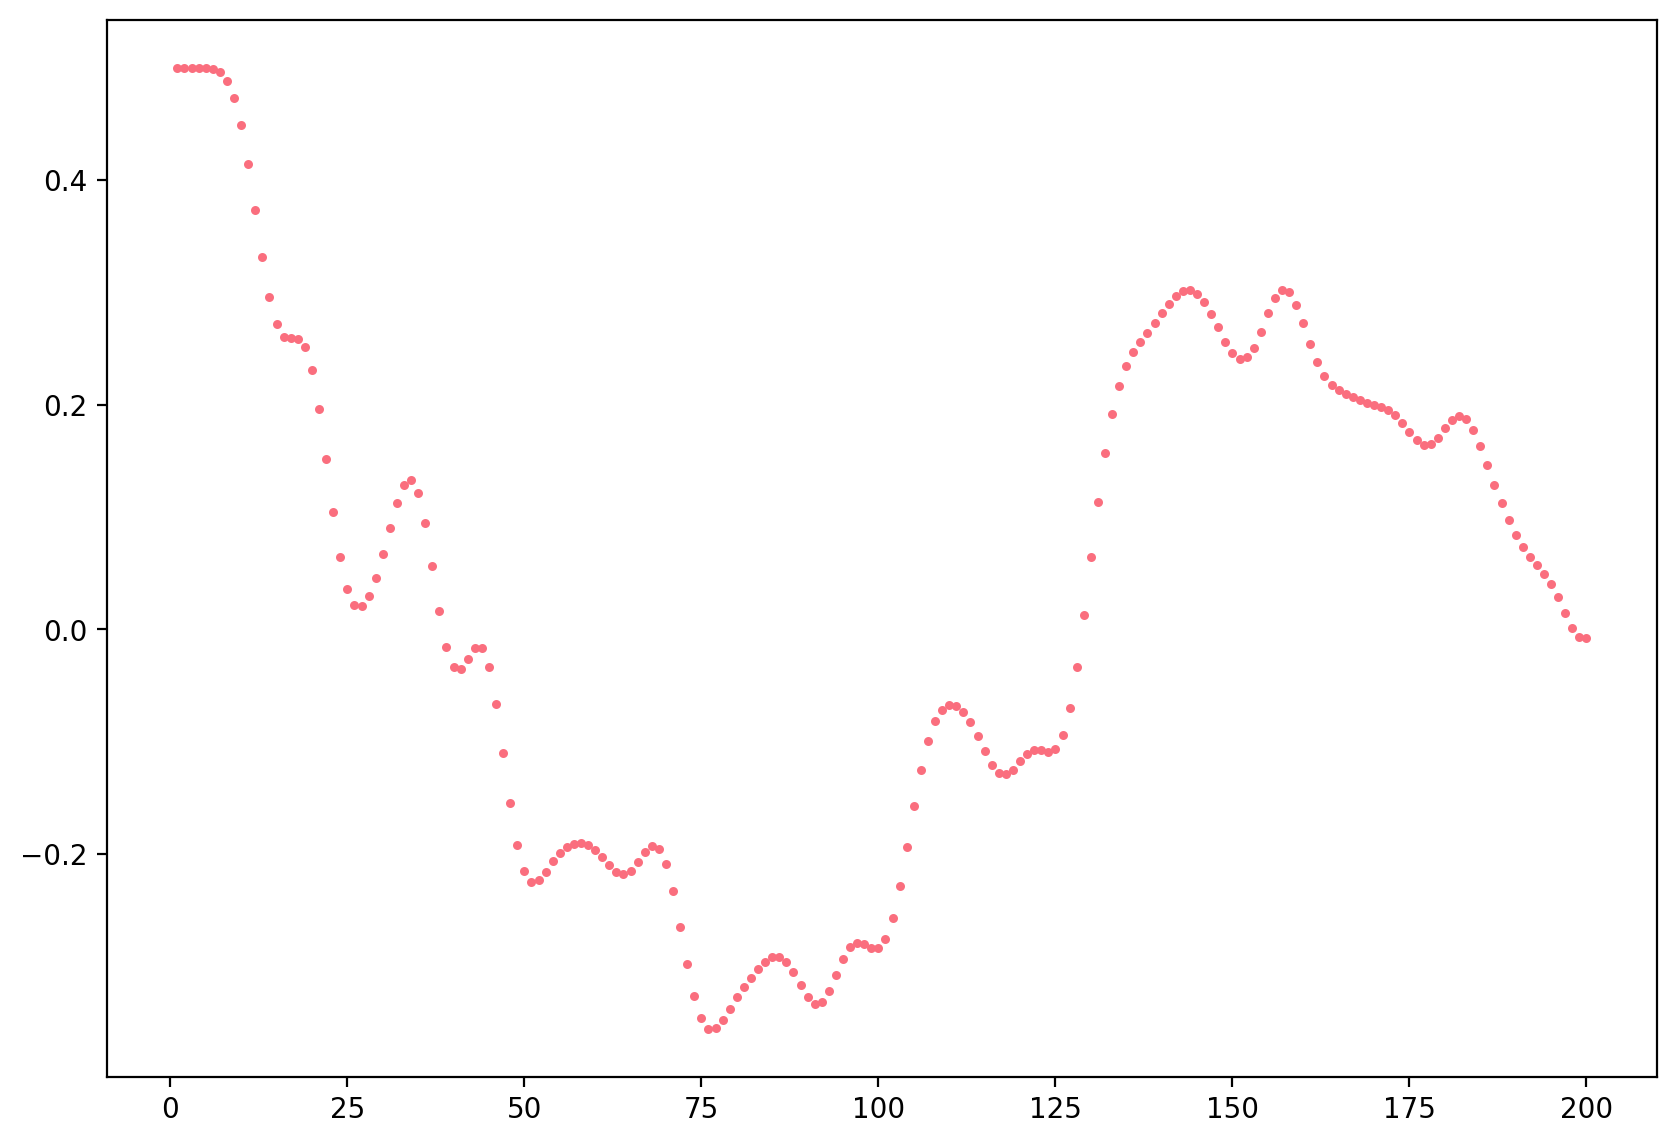

In [6]:
# print(np.where(np.imag(phi1) != 0))
# print(phi1[1])

i = 3
siTime = []
for t in range(len(phi1)): 
    sL = []
    for i in range(L):
        si = 0
        for j,bas in enumerate(basis):
            si += np.abs(phi1[t][j])**2 * bas[i]
        sL.append(si)
    siTime.append(sL)

siTime = np.array(siTime)

times = np.array([[t]*L for t in range(1,201)]).flatten()

colors = ["r", "r", "r", "r","b","b","b","b" ]

colors = [
"#fa6e7e",
"#e6678e",
"#cc6499",
"#716198",
"#555d8c",
"#3f587d",
"#30506b",
"#2a4858"
]

plt.figure(figsize=(10,7),dpi=200)
plt.scatter(times, siTime , color = colors*200, s = 10)
plt.show()

plt.figure(figsize=(10,7),dpi=200)
plt.scatter(times[::L], siTime[:,::L] , color = colors[0], s = 5)
plt.show()